In [1]:
!pip install wordcloud
!pip install tweet-preprocessor

In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import re
import tensorflow as tf
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

import preprocessor as p

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Download and Load data from Kaggle directly

In [3]:
# Install Kaggle API
!pip install --quiet kaggle

In [4]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=2c02ef7658bca8ce091a5226c3c229079809385fa19e44735c7b4c6b0774973f
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [5]:
 # Choose kaggle.json that created for new API token in your account
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"orchidchetiaphukan","key":"099afcb8eb32dde9885cd0bdf0e3389b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Check the file in its new directory
!ls /root/.kaggle/
# Check the file permission
!ls -l ~/.kaggle/kaggle.json
#Change the file permission
# chmod 600 file – owner can read and write
# chmod 700 file – owner can read, write and execute
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d 'kazanova/sentiment140'
!unzip -q sentiment140.zip  -d .

In [ ]:
! ls /content

In [ ]:
!mkdir /root/.kaggle/input

In [ ]:
!cp training.1600000.processed.noemoticon.csv  ~/.kaggle/input

In [ ]:
!ls /root/.kaggle/input

# Classification of Depressive and Normal Tweets

## Datasets

###For this analysis Sentiment140 Dataset is used 
https://www.kaggle.com/kazanova/sentiment140


In [ ]:
encoding = 'ISO-8859-1'
col_names = ['target', 'id', 'date', 'flag', 'user', 'text']

dataset = pd.read_csv('/root/.kaggle/input/training.1600000.processed.noemoticon.csv', encoding=encoding, names=col_names)

In [ ]:
dataset.head()

In [ ]:
df = dataset.copy().sample(8000, random_state=42)
df["label"] = 0
df = df[['text', 'label']]
df.dropna(inplace=True)
df.head()

In [ ]:
df.shape

### Dataset scraped by twint
https://github.com/peijoy/DetectDepressionInTwitterPosts

In [ ]:
col_names = ['id', 'text']
df2 = pd.read_csv('/content/drive/MyDrive/AI Hack/DetectDepressionInTwitterPosts-master/depressive_tweets_processed.csv', 
                  sep = '|', header = None, usecols = [0,5], nrows = 3200, names=col_names) 
df2.head()

In [ ]:
df2.info()

In [ ]:
df2.shape

In [ ]:
# add `label` colum with value 1's
df2['label'] = 1
df2 = df2[['text', 'label']]

In [ ]:
df = pd.concat([df,df2]) # merge the dataset on normal tweets and depressive tweets
df = df.sample(frac=1)  # shuffle the dataset

0 : Not Depressed

1 : Depressed

In [ ]:
df['label'].value_counts()

## Text Preprocessing

In [ ]:
# Expand Contraction
clist =  pd.read_json('eng_contractions.txt', typ='series')
clist = clist.to_dict()

In [ ]:
c_re = re.compile('(%s)' % '|'.join(clist.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)


In [ ]:
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        tweet = tweet.lower()
        tweet = BAD_SYMBOLS_RE.sub(' ', tweet)
        tweet = p.clean(tweet)
        
        #expand contraction
        tweet = expandContractions(tweet)

        #remove punctuation
        tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

        #stop words
        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet) 
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        tweet = ' '.join(filtered_sentence)
        
        cleaned_tweets.append(tweet)
        
    return cleaned_tweets

In [ ]:
X = clean_tweets([tweet for tweet in df['text']])
X = [str(i) for i in X]
print(X[0:5])

## Word Analysis

In [ ]:
depressive_tweets = [clean_tweets([t for t in df2['text']])]
depressive_words = ' '.join(list(map(str, depressive_tweets)))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False,background_color='white', colormap="GnBu_r").generate(depressive_words)

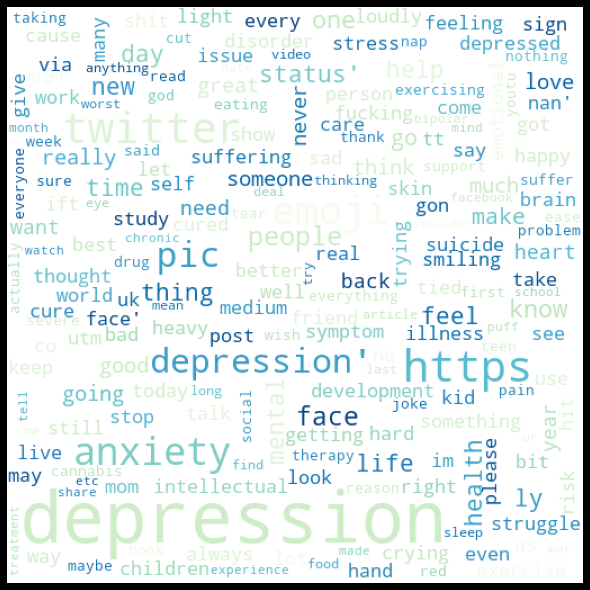

In [ ]:
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## Baseline Model

In [ ]:
# X is the Feature after TEXT CLEANING IS DONE
y = df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size = 0.1, random_state = 42)


In [ ]:
# Train data Tokenization
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each Text.
MAX_SEQ_LENGTH = 140
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS,oov_token='OOV', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
word_vector = tokenizer.texts_to_sequences(X_train)
input_tensor = pd.DataFrame(tf.keras.preprocessing.sequence.pad_sequences(word_vector, maxlen=MAX_SEQ_LENGTH))
input_tensor.head()
print('Found %s unique tokens.' % len(word_index))

Found 19233 unique tokens.


In [ ]:
# Saving the tokenizer as pickle file
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
# Test data Tokenization
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pd.DataFrame(tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_SEQ_LENGTH))
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2098,267,7,464,771,186,413,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1131,724,25,3554,1585
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,161,60,89,1038,538,3267,582,80,64,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,155,2,420,150,323,434,403,5,895,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2293,1,233,2200,2365,1,1,1,1,1,647,1,127,1,1


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97):
      print("\nReached 97% accuracy so cancelling training!")
      self.model.stop_training = True
callback = myCallback()

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/AI Hack/model/main.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')
callbacks = [callback, checkpointer]

In [ ]:
print(input_tensor.shape[1])

140


In [ ]:
EMBEDDING_DIM = 300
def create_model():
   model = tf.keras.Sequential([
                              tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length = input_tensor.shape[1]),
                              tf.keras.layers.LSTM(300),
                              tf.keras.layers.Dense(100, activation="relu"),
                              tf.keras.layers.Dropout(0.25),
                              tf.keras.layers.Dropout(0.2),
                              tf.keras.layers.Dense(1, activation='sigmoid')])

   return model

model = create_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [ ]:
history = model.fit(input_tensor, y_train, batch_size=16, epochs=1 , callbacks = callbacks,validation_split = 0.1)

 30/524 [>.............................] - ETA: 5:14 - loss: 0.4916 - accuracy: 0.7937

KeyboardInterrupt: ignored

In [ ]:
model.save('/content/drive/MyDrive/AI Hack/model/main.h5')

In [ ]:
new_model1 =  tf.keras.models.load_model('/content/drive/MyDrive/AI Hack/model/main.h5')
new_model1.summary()

In [ ]:
y_pred = (new_model1.predict(X_test) > 0.5).astype("int32")
print(y_pred)
print(type(y_pred))

In [ ]:
from sklearn.metrics import classification_report
clreport = classification_report(y_test, y_pred)
print(clreport)

In [ ]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pd.DataFrame(tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_SEQ_LENGTH))